<a href="https://colab.research.google.com/github/abh22/fraud_detect_steg/blob/main/Fraud_Detection_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling
- Preprocessing the data and feature engineering
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Prep

## Import Libraries

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')

## Read the Data

In [112]:
client_train = pd.read_csv(f'drive/MyDrive/data/client_train.csv', low_memory=False)
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [113]:
invoice_train = pd.read_csv(f'drive/MyDrive/data/invoice_train.csv', low_memory=False)
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [114]:
client_test = pd.read_csv(f'drive/MyDrive/data/client_test.csv', low_memory=False)
client_test.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [115]:
invoice_test = pd.read_csv(f'drive/MyDrive/data/invoice_test.csv', low_memory=False)


## Data Understanding

In [116]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_test.shape)

(135493, 6) (4476749, 16) (58069, 5) (1939730, 16)


In [117]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [118]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [119]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [120]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [121]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [122]:
#Getting unique values on the client train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [123]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [124]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

No missing values in train set

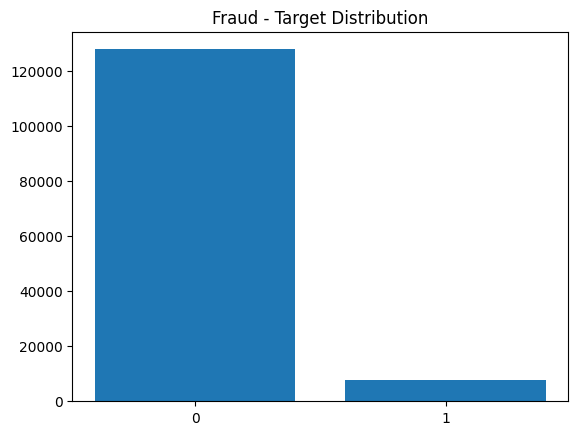

In [125]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

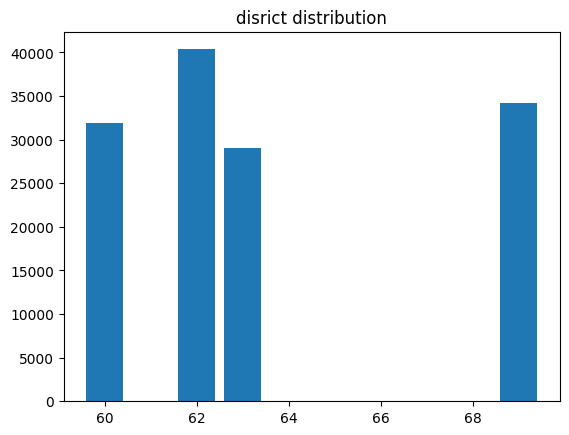

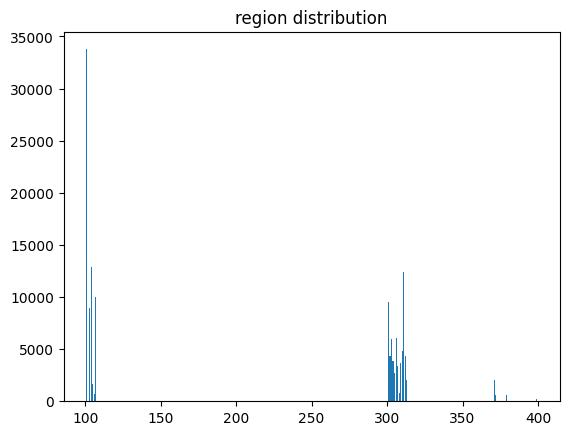

In [126]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

<Axes: xlabel='region', ylabel='count'>

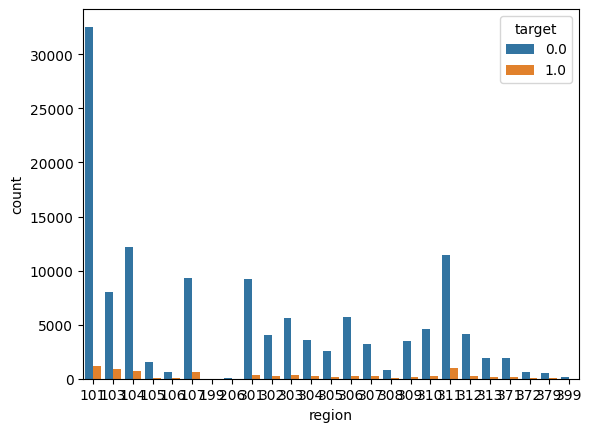

In [127]:
import seaborn as sns
sns.countplot(x='region',data=client_train,hue='target')

In [128]:
#sns.countplot(x='creation_date',data=client_train,hue='target')

In [129]:
for df in [client_train,client_test]:
    df['creation_date'] = pd.to_datetime(df['creation_date'])

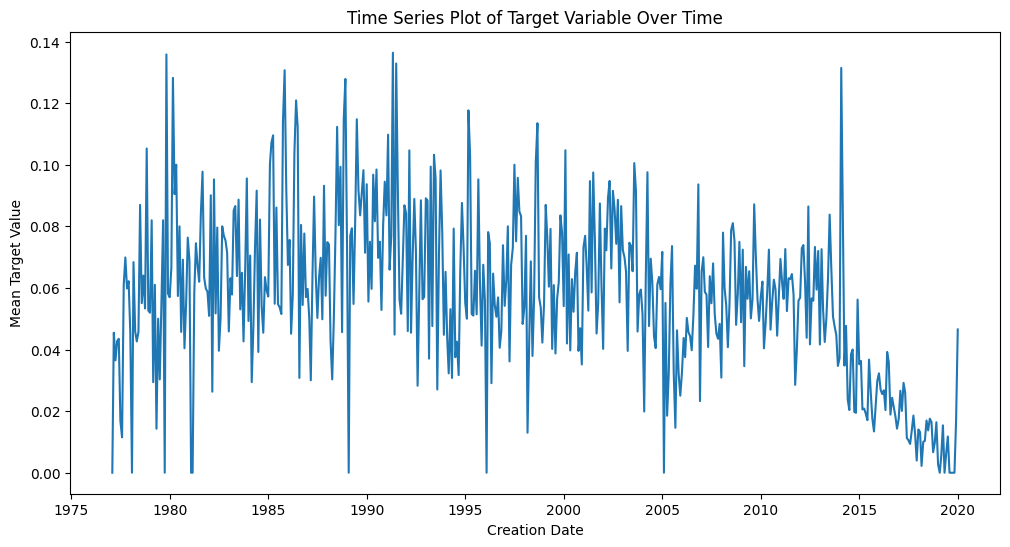

In [130]:
# Set the index to 'creation_date' for time series analysis
client_train.set_index('creation_date',inplace=True)

# Resample data by a specific time frequency (e.g., monthly)
resampled_data = client_train['target'].resample('M').mean()
client_train.reset_index(inplace=True)
# Plot the time series
plt.figure(figsize=(12, 6))
sns.lineplot(x=resampled_data.index, y=resampled_data.values)
plt.title('Time Series Plot of Target Variable Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Mean Target Value')
plt.show()


In [131]:
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   creation_date  135493 non-null  datetime64[ns]
 1   disrict        135493 non-null  int64         
 2   client_id      135493 non-null  object        
 3   client_catg    135493 non-null  int64         
 4   region         135493 non-null  int64         
 5   target         135493 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.2+ MB


In [132]:
client_train.head()

,creation_date,disrict,client_id,client_catg,region,target
0,1994-12-31,60,train_Client_0,11,101,0.0
1,2002-05-29,69,train_Client_1,11,107,0.0
2,1986-03-13,62,train_Client_10,11,301,0.0
3,1996-11-07,69,train_Client_100,11,105,0.0
4,2014-10-14,62,train_Client_1000,11,303,0.0


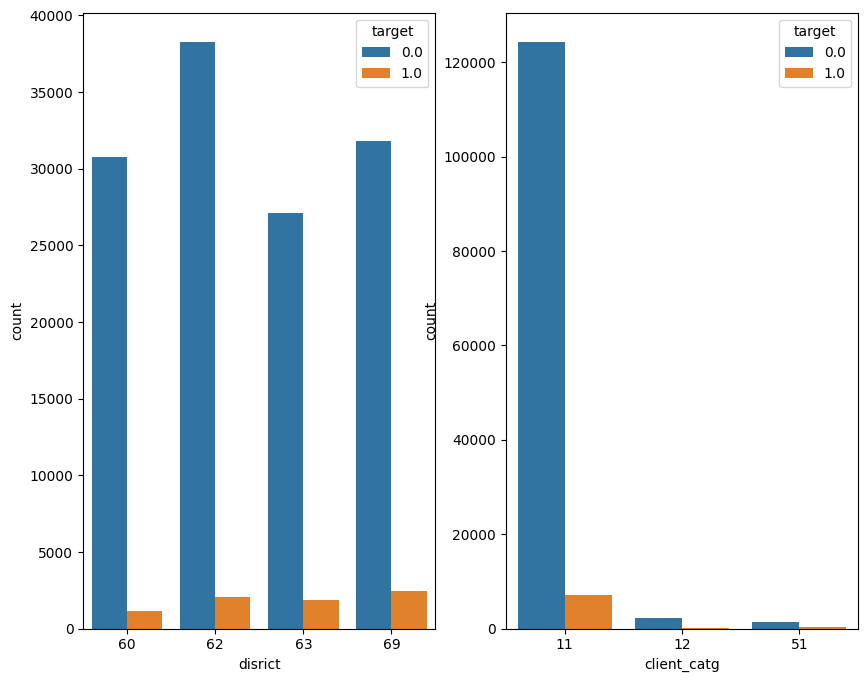

In [133]:
categ=['disrict','client_catg']
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,8))
axs=axs.flatten()
for i,elem in enumerate(categ):
  sns.countplot(x=elem,hue='target',data=client_train,ax=axs[i])
plt.show()

## Feature Engineering

In [134]:
import pandas as pd

client_train_sample = client_train.sample(n=800, random_state=42)
client_test_sample = client_test.sample(n=200, random_state=42)

In [135]:


# Merge (join) the two DataFrames on the 'id' column
merged_data = pd.merge(invoice_train, client_train, on='client_id', how='inner')

# Now, you can sample rows from the merged DataFrame
invoice_train_sample = merged_data[merged_data['client_id'].isin(client_train_sample)]



In [136]:
invoice_train_sample.shape

(0, 21)

In [186]:
client_train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 59569 to 27065
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   creation_date  800 non-null    datetime64[ns]
 1   disrict        800 non-null    int64         
 2   client_id      800 non-null    object        
 3   client_catg    800 non-null    int64         
 4   region         800 non-null    int64         
 5   target         800 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 43.8+ KB


In [137]:
client_train_sample.shape

(800, 6)

In [138]:
# Merge (join) the two DataFrames on the 'id' column
merged_data = pd.merge(invoice_test, client_test, on='client_id', how='inner')

# Now, you can sample rows from the merged DataFrame
invoice_test_sample = merged_data[merged_data['client_id'].isin(client_test_sample)]

In [139]:
invoice_test_sample.shape

(0, 20)

In [140]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [141]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [142]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype         
---  ------                -----         
 0   client_id             object        
 1   invoice_date          datetime64[ns]
 2   tarif_type            int64         
 3   counter_number        int64         
 4   counter_statue        object        
 5   counter_code          int64         
 6   reading_remarque      int64         
 7   counter_coefficient   int64         
 8   consommation_level_1  int64         
 9   consommation_level_2  int64         
 10  consommation_level_3  int64         
 11  consommation_level_4  int64         
 12  old_index             int64         
 13  new_index             int64         
 14  months_number         int64         
 15  counter_type          int64         
dtypes: datetime64[ns](1), int64(13), object(2)
memory usage: 546.5+ MB


In [143]:
import pandas as pd

def aggregate_by_client_id(invoice_data):
    # Define columns for mean aggregation
    columns_to_aggregate = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']

    # Define aggregation dictionary for mean
    aggs = {col: ['mean'] for col in columns_to_aggregate}

    # Perform aggregation
    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)

    # Flatten MultiIndex columns
    agg_trans.columns = [f'{col[0]}_{col[1]}' for col in agg_trans.columns]

    agg_trans.reset_index(inplace=True)

    # Count transactions
    transactions_count = invoice_data.groupby('client_id').size().reset_index(name='transactions_count')

    # Merge aggregated results with the original DataFrame
    result_df = pd.merge(transactions_count, agg_trans, on='client_id', how='left')

    # Include all columns from the original DataFrame without modification
    remaining_columns = [col for col in invoice_data.columns if col not in columns_to_aggregate]
    result_df = pd.merge(result_df, invoice_data[remaining_columns], on='client_id', how='left')

    return result_df



In [144]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)


In [145]:
agg_train.head(400)

,client_id,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,old_index,new_index,months_number,counter_type
0,train_Client_0,35,352.400000,10.571429,0.000000,0.0,2014-03-24,11,1335667,0,203,8,1,14302,14384,4,0
1,train_Client_0,35,352.400000,10.571429,0.000000,0.0,2013-03-29,11,1335667,0,203,6,1,12294,13678,4,0
2,train_Client_0,35,352.400000,10.571429,0.000000,0.0,2015-03-23,11,1335667,0,203,8,1,14624,14747,4,0
3,train_Client_0,35,352.400000,10.571429,0.000000,0.0,2015-07-13,11,1335667,0,207,8,1,14747,14849,4,0
4,train_Client_0,35,352.400000,10.571429,0.000000,0.0,2016-11-17,11,1335667,0,207,9,1,15066,15638,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,train_Client_100006,37,881.972973,158.567568,57.594595,0.0,2009-11-19,11,959521,0,203,6,1,13259,14102,4,0
396,train_Client_100006,37,881.972973,158.567568,57.594595,0.0,2015-12-10,11,959521,0,203,9,1,33495,34811,4,0
397,train_Client_100006,37,881.972973,158.567568,57.594595,0.0,2016-08-06,11,959521,0,203,8,1,36976,37254,2,0
398,train_Client_100006,37,881.972973,158.567568,57.594595,0.0,2016-10-14,11,959521,0,203,9,1,37254,39216,4,0


In [146]:
agg_train['client_id'].nunique()

135493

In [147]:
agg_train.isnull().sum()

client_id                    0
transactions_count           0
consommation_level_1_mean    0
consommation_level_2_mean    0
consommation_level_3_mean    0
consommation_level_4_mean    0
invoice_date                 0
tarif_type                   0
counter_number               0
counter_statue               0
counter_code                 0
reading_remarque             0
counter_coefficient          0
old_index                    0
new_index                    0
months_number                0
counter_type                 0
dtype: int64

In [148]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [149]:
unique_values = train['counter_statue'].unique()

# Display the unique values
print(unique_values)

['0' '1' '5' '4' '3' '2' '769' 'A' '618' '269375' '46' '420']


In [150]:
train['counter_statue'] = train['counter_statue'].map({'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,769:5,'A':0,'618':5,'269375':5,'46':5,'420':5})

In [151]:
train['counter_statue'].dtypes

dtype('float64')

In [152]:
train.head()

,creation_date,disrict,client_id,client_catg,region,target,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,...,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,old_index,new_index,months_number,counter_type
0,1994-12-31,60,train_Client_0,11,101,0.0,35,352.4,10.571429,0.0,...,11,1335667,0.0,203,8,1,14302,14384,4,0
1,1994-12-31,60,train_Client_0,11,101,0.0,35,352.4,10.571429,0.0,...,11,1335667,0.0,203,6,1,12294,13678,4,0
2,1994-12-31,60,train_Client_0,11,101,0.0,35,352.4,10.571429,0.0,...,11,1335667,0.0,203,8,1,14624,14747,4,0
3,1994-12-31,60,train_Client_0,11,101,0.0,35,352.4,10.571429,0.0,...,11,1335667,0.0,207,8,1,14747,14849,4,0
4,1994-12-31,60,train_Client_0,11,101,0.0,35,352.4,10.571429,0.0,...,11,1335667,0.0,207,9,1,15066,15638,12,0


In [153]:
#aggregate test set
agg_test = aggregate_by_client_id(invoice_test)
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [185]:
client_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   disrict        58069 non-null  int64         
 1   client_id      58069 non-null  object        
 2   client_catg    58069 non-null  int64         
 3   region         58069 non-null  int64         
 4   creation_date  58069 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.2+ MB


In [154]:
unique_values = test['counter_statue'].unique()

# Display the unique values
print(unique_values)

[0 1 5 4 3 2]


In [183]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1939730 entries, 0 to 1939729
Data columns (total 21 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   disrict                    int64         
 1   client_id                  object        
 2   client_catg                int64         
 3   region                     int64         
 4   creation_date              datetime64[ns]
 5   transactions_count         int64         
 6   consommation_level_1_mean  float64       
 7   consommation_level_2_mean  float64       
 8   consommation_level_3_mean  float64       
 9   consommation_level_4_mean  float64       
 10  invoice_date               datetime64[ns]
 11  tarif_type                 int64         
 12  counter_number             int64         
 13  counter_statue             int64         
 14  counter_code               int64         
 15  reading_remarque           int64         
 16  counter_coefficient        int64    

In [155]:
train.shape, test.shape

((4476749, 22), (1939730, 21))

In [156]:
train_s=train.sample(n=400, random_state=42)

In [157]:
test_s=test.sample(n=80, random_state=42)

In [158]:
test_s.head()

,disrict,client_id,client_catg,region,creation_date,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,...,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,old_index,new_index,months_number,counter_type
313704,69,test_Client_18535,11,107,2004-07-16,14,1957.785714,114.357143,0.00,0.0000,...,11,104369,0,413,8,1,34087,34911,4,0
762885,62,test_Client_30628,11,301,1985-04-17,38,155.368421,197.815789,0.00,0.0000,...,10,486192,0,202,6,1,35177,35817,4,0
1533802,69,test_Client_51305,11,107,2012-04-16,34,371.500000,2.000000,0.00,0.0000,...,40,6995563,0,5,9,1,3315,3445,4,1
1495348,60,test_Client_50263,11,101,1990-05-23,80,593.987500,73.300000,74.15,1.4375,...,40,127271,0,5,6,1,8732,9031,4,1
1479113,62,test_Client_49840,11,310,2004-05-10,103,467.446602,9.485437,0.00,0.0000,...,9,2269204,0,202,9,1,3891,4438,4,0


<Axes: >

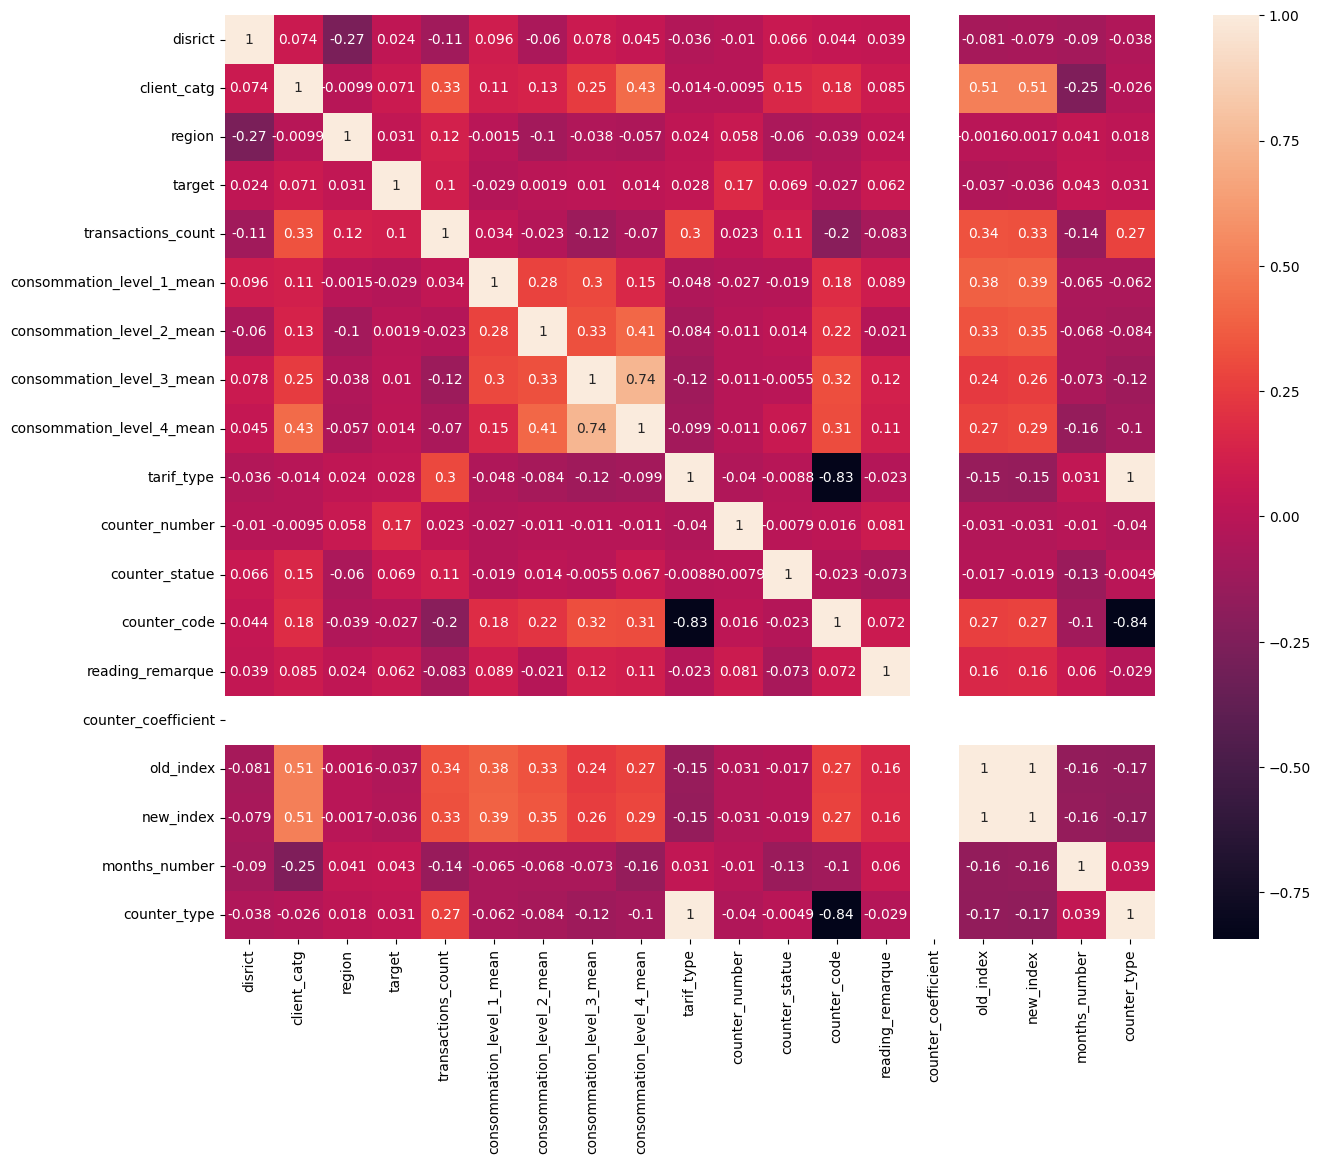

In [159]:
# @title Correlation heatmap
plt.figure(figsize=(15,12))
sns.heatmap(train_s.corr(),fmt='.2g', annot=True)

In [160]:
# @title Cyclical encoding for months
import numpy as np
invoice_train['sin_month'] = np.sin(2 * np.pi * invoice_train['invoice_date'].dt.month / 12)
invoice_train['cos_month'] = np.cos(2 * np.pi * invoice_train['invoice_date'].dt.month / 12)



In [161]:

invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,sin_month,cos_month
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,0,1.0,6.123234e-17
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,0,1.0,6.123234e-17
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,0,1.0,6.123234e-17
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,0,-0.5,-8.660254e-01
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,0,-0.5,8.660254e-01


In [162]:
# @title merging months encoding with train
# Assuming 'client_id' is the common key
import pandas as pd
train_f = pd.merge(train_s, invoice_train[['client_id', 'sin_month', 'cos_month']], on='client_id', how='left')


In [163]:
train_f.shape


(21369, 24)

In [164]:
train_f = train_f.sample(n=400, random_state=42)

In [165]:
# Assuming 'invoice_date' needs to be converted to datetime
train_f['invoice_date'] = pd.to_datetime(train_f['invoice_date'])


In [166]:
train_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 17977 to 11811
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   creation_date              400 non-null    datetime64[ns]
 1   disrict                    400 non-null    int64         
 2   client_id                  400 non-null    object        
 3   client_catg                400 non-null    int64         
 4   region                     400 non-null    int64         
 5   target                     400 non-null    float64       
 6   transactions_count         400 non-null    int64         
 7   consommation_level_1_mean  400 non-null    float64       
 8   consommation_level_2_mean  400 non-null    float64       
 9   consommation_level_3_mean  400 non-null    float64       
 10  consommation_level_4_mean  400 non-null    float64       
 11  invoice_date               400 non-null    datetime64[ns]
 12  ta

In [167]:
invoice_test['sin_month'] = np.sin(2 * np.pi * invoice_test['invoice_date'].dt.month / 12)
invoice_test['cos_month'] = np.cos(2 * np.pi * invoice_test['invoice_date'].dt.month / 12)
test_f = pd.merge(test_s, invoice_test[['client_id', 'sin_month', 'cos_month']], on='client_id', how='left')
test_f.head()

,disrict,client_id,client_catg,region,creation_date,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,...,counter_statue,counter_code,reading_remarque,counter_coefficient,old_index,new_index,months_number,counter_type,sin_month,cos_month
0,69,test_Client_18535,11,107,2004-07-16,14,1957.785714,114.357143,0.0,0.0,...,0,413,8,1,34087,34911,4,0,1.224647e-16,-1.000000e+00
1,69,test_Client_18535,11,107,2004-07-16,14,1957.785714,114.357143,0.0,0.0,...,0,413,8,1,34087,34911,4,0,-5.000000e-01,-8.660254e-01
2,69,test_Client_18535,11,107,2004-07-16,14,1957.785714,114.357143,0.0,0.0,...,0,413,8,1,34087,34911,4,0,-5.000000e-01,8.660254e-01
3,69,test_Client_18535,11,107,2004-07-16,14,1957.785714,114.357143,0.0,0.0,...,0,413,8,1,34087,34911,4,0,-5.000000e-01,-8.660254e-01
4,69,test_Client_18535,11,107,2004-07-16,14,1957.785714,114.357143,0.0,0.0,...,0,413,8,1,34087,34911,4,0,1.000000e+00,6.123234e-17


In [168]:
test_f=test_f.sample(n=80,random_state=42)

In [169]:
test_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 1743 to 1210
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   disrict                    80 non-null     int64         
 1   client_id                  80 non-null     object        
 2   client_catg                80 non-null     int64         
 3   region                     80 non-null     int64         
 4   creation_date              80 non-null     datetime64[ns]
 5   transactions_count         80 non-null     int64         
 6   consommation_level_1_mean  80 non-null     float64       
 7   consommation_level_2_mean  80 non-null     float64       
 8   consommation_level_3_mean  80 non-null     float64       
 9   consommation_level_4_mean  80 non-null     float64       
 10  invoice_date               80 non-null     datetime64[ns]
 11  tarif_type                 80 non-null     int64         
 12  count

In [170]:
#drop redundant columns
sub_client_id = test_f['client_id']
drop_columns = ['client_id', 'creation_date','invoice_date']

for col in drop_columns:
    if col in train.columns:
        train_f.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test_f.drop([col], axis=1, inplace=True)

# Modelling

## Train LGBM *Classifier*

In [171]:
x_train = train_f.drop(columns=['target'])
y_train = train_f['target']

In [172]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 17977 to 11811
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   disrict                    400 non-null    int64  
 1   client_catg                400 non-null    int64  
 2   region                     400 non-null    int64  
 3   transactions_count         400 non-null    int64  
 4   consommation_level_1_mean  400 non-null    float64
 5   consommation_level_2_mean  400 non-null    float64
 6   consommation_level_3_mean  400 non-null    float64
 7   consommation_level_4_mean  400 non-null    float64
 8   tarif_type                 400 non-null    int64  
 9   counter_number             400 non-null    int64  
 10  counter_statue             400 non-null    float64
 11  counter_code               400 non-null    int64  
 12  reading_remarque           400 non-null    int64  
 13  counter_coefficient        400 non-null    i

In [173]:
model = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)
model.fit(x_train, y_train)

[LightGBM] [Warning] Unknown parameter: num_iterationss
[LightGBM] [Warning] Unknown parameter: num_iterationss
[LightGBM] [Info] Number of positive: 41, number of negative: 359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102500 -> initscore=-2.169750
[LightGBM] [Info] Start training from score -2.169750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

LGBMClassifier(num_iterationss=500)

In [174]:
x_train.disrict.unique()

array([69, 60, 62, 63])

## Make Predictions on test set

In [177]:
test_f.columns

Index(['disrict', 'client_catg', 'region', 'transactions_count',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean', 'tarif_type',
       'counter_number', 'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'old_index', 'new_index', 'months_number',
       'counter_type', 'sin_month', 'cos_month'],
      dtype='object')

In [178]:
preds = model.predict(test_f)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

[LightGBM] [Warning] Unknown parameter: num_iterationss


,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [182]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

,client_id,target
0,NaN,0.0
1,NaN,0.0
2,NaN,0.0
3,NaN,0.0
4,NaN,0.0
5,NaN,0.0
6,NaN,0.0
7,NaN,0.0
8,NaN,0.0
9,NaN,0.0


In [188]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


true_labels = client_train['target']

# Assuming 'test_f' has a 'client_id' column
# Merge the predictions DataFrame with true labels using 'client_id'
client_train['client_id'] = client_train['client_id'].astype(int)
test_f['client_id'] = test_f['client_id'].astype(int)
merged_df = pd.merge(client_train, preds, left_on='client_id', right_index=True)

# Convert predicted probabilities to class labels (assuming binary classification)
merged_df['predicted_labels'] = (merged_df['target'] > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(merged_df['target'], merged_df['predicted_labels'])

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


ValueError: invalid literal for int() with base 10: 'train_Client_0'

In [180]:
sub_client_id

1743    test_Client_26847
2196    test_Client_45921
1728    test_Client_26847
3337    test_Client_11785
298     test_Client_17771
              ...        
3746    test_Client_19760
432     test_Client_23248
2630    test_Client_25961
1598    test_Client_38915
1210    test_Client_10273
Name: client_id, Length: 80, dtype: object

In [ ]:
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

## Tips
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************